In [1]:
#scientific libraries and plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import awkward as ak

#torch specific
import torch
import torchvision as torchv
import torch.optim as optim

#other libraries
import time
import sys
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import atlas_mpl_style as ampl
from tqdm import tqdm
#Using newest versions of all libraries

In [2]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning import *
from resnet import *
from imcal import *

from resnet import ResNet18

# Predict using resnet

This notebook uses a saved resnet model to predict on test data and generate a confusion matrix. It also saves the wrong predictions for further analysis.

In [3]:
#variables controlled by the user. Change these to fit your specific needs.
RES = 50 #resolution

LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n4_M8", "BH_n2_M10", "BH_n4_M10", "BH_n6_M10", "BH_n4_M12"]
TEST_LABELS = [f"{label}_test" for label in LABELS]
PLOT_LABELS = ["SPH_9", "BH_n4_M8", "BH_n2_M10", "BH_n4_M10", "BH_n6_M10", "BH_n4_M12"]
CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
FOLDERS = ["sph", "BH", "BH", "BH", "BH", "BH"]
TEST_N_EVENTS = 15000
CUT=True

#Set data paths
if CUT:
    N_EVENTS = 15000
    TEST_FILENAMES = [f"{label}_res{RES}_STmin7_Nmin5_{N_EVENTS}_events.h5" for label in TEST_LABELS]
else:
    N_EVENTS = 3000
    TEST_FILENAMES = [f"{label}_res{RES}_{N_EVENTS}_events.h5" for label in TEST_LABELS]
TEST_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{TEST_FILENAMES[i]}" for i in range(CLASSES)]

MODEL_NAME = "resnet_1696929580_SPH_9_BH_n4_M8_BH_n2_M10_BH_n4_M10_BH_n6_M10_BH_n4_M12_CUT_res50"
LOAD_FOLDER = "../results/models"
LOAD_PATH = f"{LOAD_FOLDER}/{MODEL_NAME}.pt"

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    torch.cuda.empty_cache()
    print("Running on the GPU")
else:
    DEVICE = torch.device("cpu")
    print("Running on the CPU")
DEVICE = torch.device("cpu")
ampl.use_atlas_style() 

Running on the GPU


In [9]:
#import model
model = ResNet18(img_channels=3, num_classes=len(TEST_LABELS))
model.load_state_dict(torch.load(LOAD_PATH))
model.eval()
model.to(DEVICE)
print("Loading model")

Loading model


In [10]:
#Load data
testpaths = [Path(path) for path in TEST_DATAPATHS]
print(testpaths)

test_data = Hdf5Dataset(testpaths, TEST_LABELS, DEVICE, 
                        shuffle=False, filters=[None], transform=None, event_limit=TEST_N_EVENTS)
eventids = test_data.getids().flatten()
if len(eventids) != len(test_data):
    print("Error in lengths of arrays")

[PosixPath('/disk/atlas3/data_MC/2dhistograms/sph/50/PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_test_res50_STmin7_Nmin5_15000_events.h5'), PosixPath('/disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M8_test_res50_STmin7_Nmin5_15000_events.h5'), PosixPath('/disk/atlas3/data_MC/2dhistograms/BH/50/BH_n2_M10_test_res50_STmin7_Nmin5_15000_events.h5'), PosixPath('/disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M10_test_res50_STmin7_Nmin5_15000_events.h5'), PosixPath('/disk/atlas3/data_MC/2dhistograms/BH/50/BH_n6_M10_test_res50_STmin7_Nmin5_15000_events.h5'), PosixPath('/disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M12_test_res50_STmin7_Nmin5_15000_events.h5')]
Opening file /disk/atlas3/data_MC/2dhistograms/sph/50/PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_test_res50_STmin7_Nmin5_15000_events.h5.
Selecting 15000 events out of 15000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M8_test_res50_STmin7_Nmin5_15000_events.h5.
Selecting 15000 events out of 15000.
Opening file /disk/atlas3/data_MC/2

In [46]:
truth, preds, confidences = predict(model, test_data, CLASSES, 100, RES, DEVICE, return_values=True)


100%|██████████| 900/900 [01:38<00:00,  9.16it/s]


In [100]:
df = pd.DataFrame(dict(zip(["Truth", "Prediction"], [truth, preds])))
df["EventID"] = eventids
accuracy = accuracy_score(truth, preds, normalize=True)

In [101]:
df['Confidence'] = torch.max(confidences, dim=-1)[0]

[92.15  5.11  2.29  0.21  0.15  0.1  13.16 64.82  9.24  6.5   5.58  0.7
 13.07 14.47 39.01 16.33 13.01  4.12  7.59 16.87 29.13 21.02 20.89  4.49
  5.62 18.79 25.22 20.83 24.8   4.74  2.47  2.96 13.91  7.97 11.2  61.49]
Accuracy: 0.5054666666666666


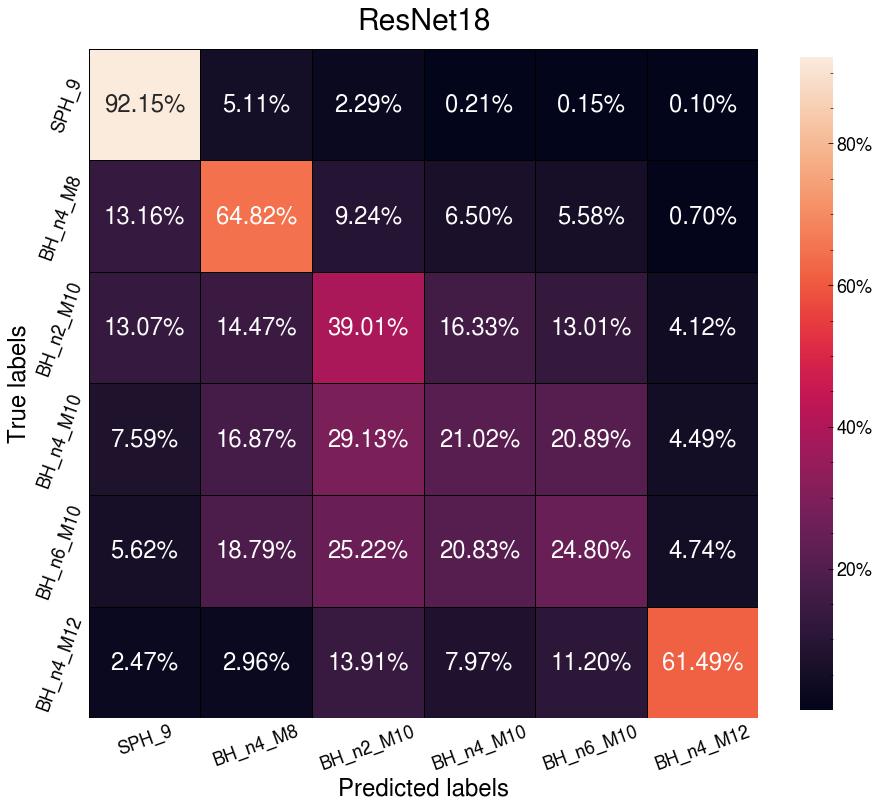

In [102]:
def plot_conf_matrix(confusion, accuracy, labels):
    """
    plot confusion matrix
    """
    fig, ax = plt.subplots(1,1, figsize=(15, 15))

    #Generate the confusion matrix
    cf_matrix = confusion_matrix(confusion["Truth"], confusion["Prediction"], normalize="true")
    cf_matrix = 100*np.round(cf_matrix, 4)
    print(cf_matrix.flatten())
    group_counts = ["{0:0.0f}".format(value*TEST_N_EVENTS) for value in cf_matrix.flatten()]
    group_percentages = ["{0:0.2%}".format(value/100) for value in cf_matrix.flatten()]
    annot = [f"{item}" for item in group_percentages]
    annot = np.asarray(annot).reshape(len(labels),len(labels))
    sn.heatmap(
            cf_matrix, 
            ax=ax, 
            annot=annot, 
            cmap='rocket', 
            linewidths=1.0, 
            linecolor='black',
            cbar = True, 
            square=True, 
            fmt='', 
            cbar_kws={"format": "%.0f%%", "shrink": 0.8},
            annot_kws={"size": 24}
        )

    #ax.set_title('Confusion matrix\n\n', size=24)
    ax.set_xlabel('Predicted labels', size=24)
    ax.set_ylabel('True labels', size=24)

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(labels, size=18, rotation=20)
    ax.yaxis.set_ticklabels(labels, size=18, rotation=70)
    ax.tick_params(which="both", left=False, bottom=False, top=False, right=False)
    ax.set_title(f"ResNet18", size=30, pad=20)
    print(f"Accuracy: {accuracy}")

    ## Display the visualization of the Confusion Matrix.
    plt.show()
plot_conf_matrix(df, accuracy, PLOT_LABELS)

In [103]:
df_wrong = df[df["Prediction"] != df["Truth"]]

In [109]:
#Look at the confidences
for i in range(len(LABELS)):
    temp = df[df["Truth"]==i]
    temp_len = len(temp)
    print(f"Predictions on truth {temp_len} {LABELS[i]} events:")
    for j in range(len(LABELS)):
        temp_preds = temp[temp["Prediction"]==j]
        print(f"{len(temp_preds)} events predicted as {LABELS[j]}")
        print(f"Average confidence: {temp_preds['Confidence'].mean()}, Std: {temp_preds['Confidence'].std()}")
    print("----")


Predictions on truth 15000 PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL events:
13822 events predicted as PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL
Average confidence: 0.8700000047683716, Std: 0.1622215360403061
767 events predicted as BH_n4_M8
Average confidence: 0.5299999713897705, Std: 0.18220341205596924
343 events predicted as BH_n2_M10
Average confidence: 0.36000001430511475, Std: 0.08368005603551865
31 events predicted as BH_n4_M10
Average confidence: 0.3100000023841858, Std: 0.03979865834116936
22 events predicted as BH_n6_M10
Average confidence: 0.3100000023841858, Std: 0.05596724897623062
15 events predicted as BH_n4_M12
Average confidence: 0.36000001430511475, Std: 0.10360773652791977
----
Predictions on truth 15000 BH_n4_M8 events:
1974 events predicted as PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL
Average confidence: 0.6299999952316284, Std: 0.20811673998832703
9723 events predicted as BH_n4_M8
Average confidence: 0.6600000262260437, Std: 0.210055872797966
1386 events predicted as BH_n

[0.00000000e+00 1.00000000e-04 3.57333333e-02 1.12188889e-01
 5.81777778e-02 3.90777778e-02 3.91444444e-02 5.47666667e-02
 1.66277778e-01]


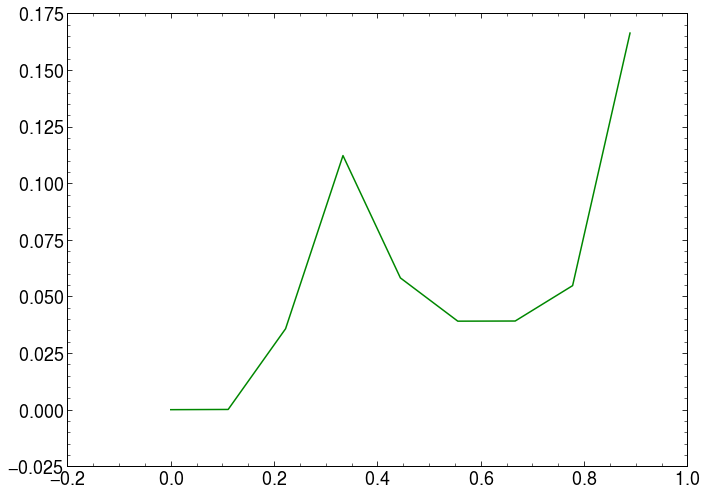

In [137]:
#Reliability diagram
conf_bins = np.linspace(0, 1, 10)
N_conf, bins = np.histogram(df['Confidence'].values, conf_bins)
N_conf_wrong = np.histogram(df_wrong['Confidence'].values, conf_bins)[0]
N_conf_right = N_conf - N_conf_wrong
n_conf_right = N_conf_right/len(df)
print(n_conf_right)
plt.plot(conf_bins[0:-1], n_conf_right)

In [111]:
def save_wrong_predictions(truths, labels, eventids, savepath, filename):
    file = open(f"{savepath}/{filename}.csv", "w")
    file.write(f"Wrongly predicted events from datasets: {testpaths} by model {MODEL_NAME}")
    for i, truth in enumerate(truths):
        file.write(f"{labels[int(truth)]}, {eventids[i]}\n")
    file.close()
    print(f"Saved results to {savepath}/{filename}.csv")
    
filename = f"{MODEL_NAME}_{TEST_N_EVENTS}_events_wrongly_predicted"
save_wrong_predictions(df_wrong["Truth"].tolist(), PLOT_LABELS, df_wrong["EventID"].tolist(), "../results/", filename)

Saved results to ../results//resnet_1696929580_SPH_9_BH_n4_M8_BH_n2_M10_BH_n4_M10_BH_n6_M10_BH_n4_M12_CUT_res50_15000_events_wrongly_predicted.csv
